In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(7)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# reading data into dataframe - train dataset, test dataset
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.shape, test.shape

((891, 11), (418, 10))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


`Survived` column is the target. And the remaining 10 columns form features. Out of 10, 5 are objects data type. Remaining are numericals.

In [5]:
# missing values in the train dataset

data_na = train.isna().sum()
data_na[data_na>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

Out of 10 features in train data, 3 have missing values. `Cabin` leads the list with more than half of its data missing (687/891). `Age` has 177 missing values, quite a number. `Embarked` column has only 2 missing values.

In [6]:
# missing values in test dataset

test_na = test.isna().sum()
test_na[test_na>0]

Age       86
Fare       1
Cabin    327
dtype: int64

Similar to train dataset, column `Cabin` has a huge missing values (327/418) in the test dataset. `Age` has considerable number of missing data (86/418). And `Fare` has one missing value, an odd thing compared to train dataset.

# Feature Engineering

Since feature `Cabin` has enormous number of missing values, the column can be dropped from both train and test datasets. By intuition, it can be said that `Age` is one of the important parameters which decide the survival rate. So `Age` column cannot be dropped at all. On the other hand, filling them with anonymous values may lead to noise in data. Hence it is better to drop the rows with `NaN` values in `Age` feature from the train dataset. However, no row can be dropped from test dataset as it is not permitted. By visualizing the distribution of feature `Age`, some good imputation can be made in test dataset. Regarding `Embarked` in train dataset and `Fare` in test dataset, simple imputation with modal values can be a good one!


By observing the data, it can be concluded that the `Name` of passenger and `Ticket` Number could not have any effect on survival. Hence we can simply drop those two columns from the datasets.

In [7]:
train.drop(['Name','Cabin','Ticket'], axis=1, inplace=True)
test.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

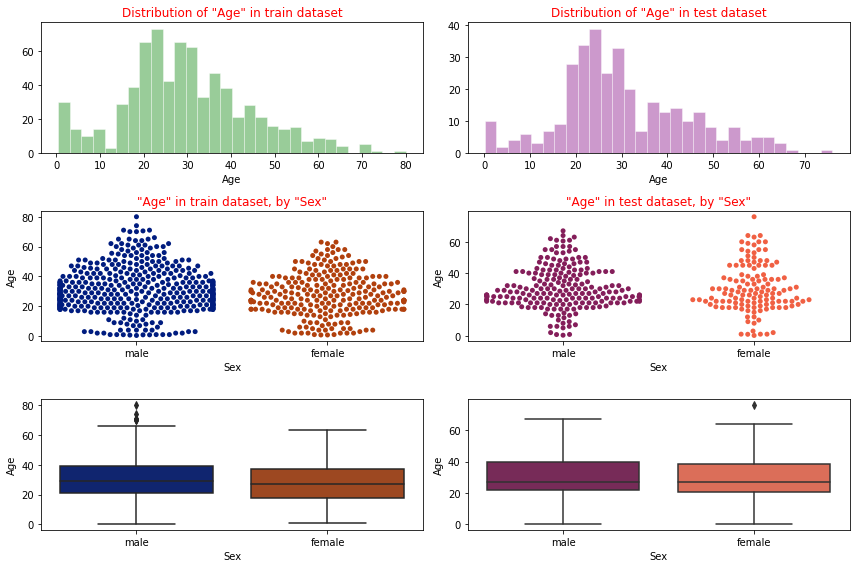

In [8]:
fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize=(12,8))
sns.set_style("darkgrid")
sns.distplot(train['Age'], color = 'green', kde=False, bins=30, ax=ax1)
sns.distplot(test['Age'], color = 'purple', kde=False, bins=30, ax=ax2)
sns.swarmplot(train['Sex'], train['Age'], palette='dark', ax=ax3)
sns.swarmplot(test['Sex'], test['Age'], palette ='rocket', ax=ax4)
sns.boxplot(train['Sex'], train['Age'], palette='dark', ax=ax5)
sns.boxplot(test['Sex'], test['Age'], palette ='rocket', ax=ax6)
ax1.set_title('Distribution of "Age" in train dataset', color='red')
ax2.set_title('Distribution of "Age" in test dataset', color='red')
ax3.set_title('"Age" in train dataset, by "Sex"', color='red')
ax4.set_title('"Age" in test dataset, by "Sex"', color='red')
plt.tight_layout()
plt.show()


It is clearly visualized that `Age` of most travellers lie within 20 to 30 years, for both the gender cases of Men and Women. Hence it is wise to fill the missing values in the `Age` column of test dataset with modal value. 

In [9]:
# fill NaN of train and test dataset with modal values
train.Embarked = train.Embarked.fillna(train.Embarked.value_counts().index[0])

test.Fare = test.Fare.fillna(test.Fare.value_counts().index[0])
test.Age = test.Age.fillna(test.Age.value_counts().index[0])

# drop rows in train dataset which have missing values in `Age` feature
train = train.dropna()

# Encoding categorical features
Now all the missing values are either removed or filled in a meaningful manner. Now it is time to observe categorical data closely and encode them suitably.

In [10]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

# Split features and target in the train data
X = train.drop('Survived', axis=1)
y = train['Survived']

# identify categorical features
object_cols = [i for i in train.columns if train[i].dtype=='object']

X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)

enc = TargetEncoder(cols = object_cols)
X_train[object_cols] = enc.fit_transform(X_train[object_cols], y_train)
X_valid[object_cols] = enc.transform(X_valid[object_cols])
test[object_cols] = enc.transform(test[object_cols])

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Statistical analysis

All of our data are processed to be suitable for statistical analysis and model building! The correlation between various features and target can now be explored.

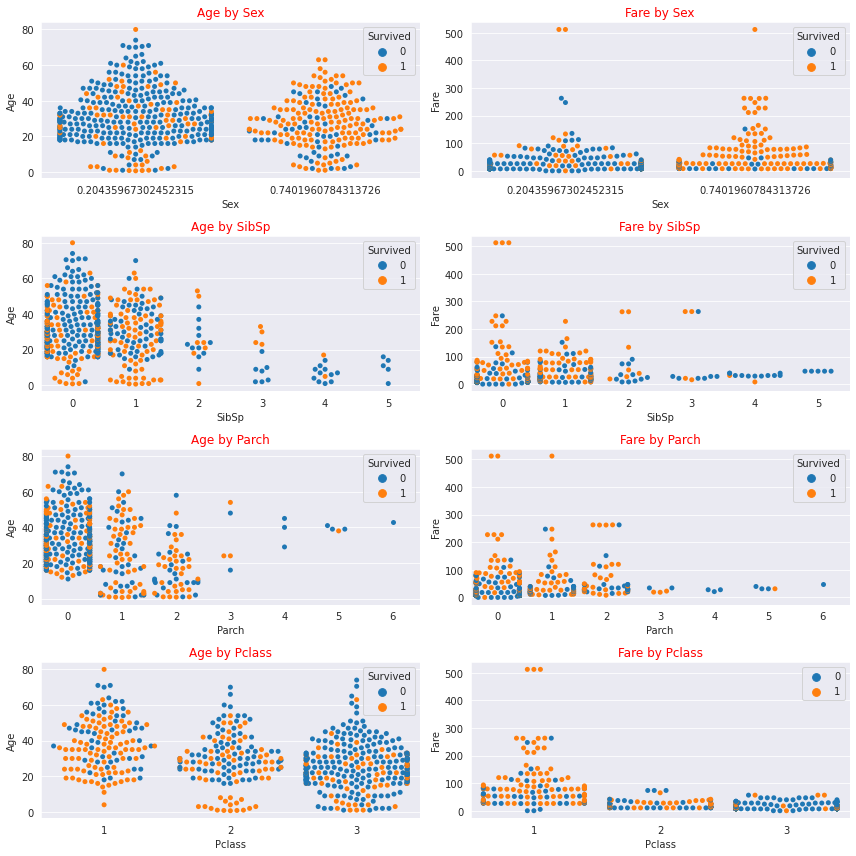

In [11]:
merge_train = X_train.join(y_train)
fig, ax = plt.subplots(4,2, figsize=(12,12))
for i, cat in enumerate(['Sex', 'SibSp','Parch', 'Pclass']):
    for j, col in enumerate(['Age', 'Fare']):
        sns.swarmplot(y=merge_train[col], x=merge_train[cat], hue=merge_train['Survived'],ax=ax[i][j])
        ax[i][j].set_title(str(col)+' by '+str(cat), color='red')

plt.tight_layout()
plt.legend()
plt.show()


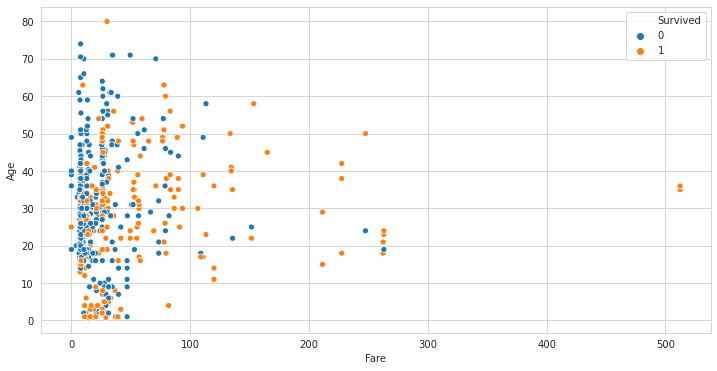

In [12]:
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
sns.scatterplot(x=merge_train['Fare'], y=merge_train['Age'], hue=merge_train['Survived'])
plt.show()

**Visualizations are always great in analysis! Some observations are summarized here:**

1. It is clear that most of the survivors are women compared to men (Target Encoding changed the categorical values into floating integers).

2. Women's fare are comparitevly higher than men's fare. Therefore it can also be stated that survival rate is more for "high" fare travellers.

3. Most travellers have either Zero or One sibling/spouse travelled along with them. Few travellers have two, three or four siblings/spouse. And most travellers have Zero/One/Two parents or children along with them. Few travellers have more than two persons who are either parents or children. 

4. Rate of survival of a traveller diminishes as the number of siblings, spouse, parents and children who travel along with them increases. In other words, lone travellers have more survival rate than that of who travel with family.

5. Most of the FIRST class travellers survived and most of the THIRD class travellers died. It ensures the statement that survival rate of travellers who spent more on 'fare' is higher.

6. It can be observed that the age of FIRST class travellers are mostly above 20 years. Most of the travellers of age less than 15 are in THIRD class. 

7. Therefore it can be expressed that *family* travellers with children choose THIRD class mostly. It ensures the statement that *Family* travellers fail to survive (In my personal view, the objective of saving the family diminished self-survival rate, while lone travellers might have the single objective of self-survival)!

# Modelling

It is time to select the algorithm, train the model, validate it and test it!

In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix

train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_valid, label=y_valid)

parameters = {'num_leaves':64, 'objective':'binary', 'metric':'auc', 'seed':7}
num_round = 1000
model = lgb.train(parameters, train_set, num_round, valid_sets=[valid_set], early_stopping_rounds=10, verbose_eval=False)

# model training finished
# validation starts --- find the optimal threshold value

pred = pd.Series(model.predict(X_valid))
values = np.arange(0,1.0,0.01)

opt={}
for t in values:
    pred_1 = pd.Series(pred).map( lambda x: 1 if x>t else 0)
    accu = accuracy_score(y_valid, pred_1)
    opt[t] = accu

threshold = max(opt.items(), key = lambda x: x[1])[0]

# accuracy of validation for optimal threshold
prediction = pd.Series(pred).map( lambda x: 1 if x>threshold else 0)
accuracy = accuracy_score(y_valid, prediction)
print('Validation Accuracy :', accuracy)
conf = confusion_matrix(y_valid, prediction)
print('Confusion matrix: ', conf)

Validation Accuracy : 0.8461538461538461
Confusion matrix:  [[72  7]
 [15 49]]


In [14]:
# predicting test dataset

final_pred = model.predict(test)
binary = pd.Series(final_pred).map( lambda x: 1 if x>threshold else 0)
output = pd.DataFrame({'PassengerId':test.index, 'Survived':binary})
output.to_csv('submission.csv', index=False)